In [492]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

This notebook analyzes three sets of sort-seq data for the first round helix sliding pilot library, which contains single state designs which should not bind Nb-ALFA (min 0) and those which should bind Nb-ALFA (min 2), along with bm01 control constructs. 

The three input data sets include the following:
(1) yeast proteolysis assay data with trypsin. (Designs have very few bulky hydrophobics and on the whole are more resistant to chymotrypsin so trypsin is likely more informative.)
(2) expression enrichment data for the library sorted into myc+ and myc- populations based on a C-termianl myc tag. Enrichment is expressed as both myc+/myc- enrichment and myc+/unsorted.
(3) tite-seq data using dynamic gating per Phillips et al., 2021. 

Together these data can be used to parse several possible outcomes for designs:
(1) designed binder and non-binder designs behaving as expected by titration data with good expression and moderate stability score are candidates for folding and behaving as expected.
(2) designed binders binding less than expected with low expression and/or very high stability score may be aggregating.
(3) designed non-binders binding more than expected with low stability score may be unfolded on the yeat surface exposing the binding motif.
(4) designed single state binders binding moderately less than expected with good expression and moderate stability could be candidate switches, even though designed as single state.

In [493]:
####USER DEFINED VARIABLES####
prot_stab_path = '/Users/stephaniecrilly/Kortemme_lab/helix_sliding/20240304_ngs_data/30-993725825/rocklin_analysis/20240304_r1hs_rep1_ Trypsin_protein_w_design_type.csv' #trypsin data only
exp_path = '/Users/stephaniecrilly/Kortemme_lab/switch_seq/r1-hs-pilot_rep1_expression.csv'
kds_path = '/Users/stephaniecrilly/Kortemme_lab/switch_seq/r1-hs_tite-seq_rep2_fixed_swapped_samples_Kds.csv'

outdir = '/Users/stephaniecrilly/Kortemme_lab/switch_seq/'
fig_outdir = '/Users/stephaniecrilly/Kortemme_lab/helix_sliding/figures'
exp_id = 'r1-hs-pilot_rep2_fixed_swapped_samples'
####

In [494]:
#read in data
prot_stab_df = pd.read_csv(prot_stab_path).rename({'Name':'design'}, axis=1)
exp_df = pd.read_csv(exp_path).rename({'Name':'design'}, axis=1)
kds_df = pd.read_csv(kds_path).rename({'geno':'design'}, axis=1)

print(prot_stab_df.shape)
print(exp_df.shape)
print(kds_df.shape)

(97, 46)
(92, 13)
(97, 7)


In [495]:
#quality filtering of data
# prot_stab_df = prot_stab_df.query('ec50_95ci < 2.0', engine='python').copy()
#filter Kds on err and fit

#inferred Kds outside of titration range binned to bounds of range

#plotting all data for now

In [496]:
#merge dfs
prot_stab_kds_df = pd.merge(prot_stab_df, kds_df, on='design', how='left')
prot_stab_exp_df = pd.merge(prot_stab_df, exp_df, on='design', how='left')
kds_exp_df = pd.merge(kds_df, exp_df, on='design', how='left')
all_merge_df = pd.merge(prot_stab_kds_df, exp_df, on='design', how='left')
print(all_merge_df.shape)
#all_merge_df.to_csv(f'{outdir}/{exp_id}_tryp_prot_stab_kds_exp.csv', index=False)

(97, 64)


Possible metrics that may be correlated are the upper asymptote of the titration curve fits to the tite-seq data (reflecting total number of moelcules available for binding) and the expression enrichment in myc+. 

Plotting these below and taking a Pearson correlation shows very low correlation. 

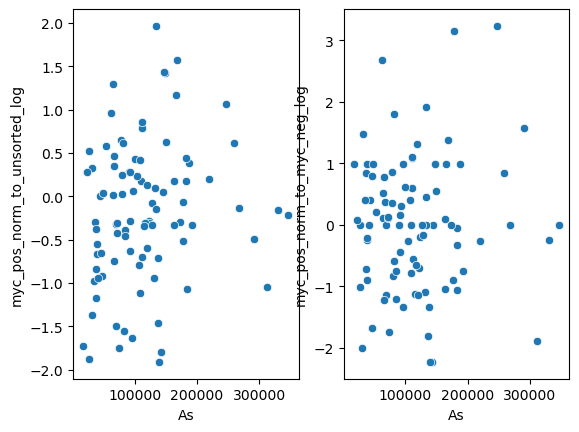

0.1677617296188091
0.04734670744369682


In [497]:
plt.subplot(1,2,1)
sns.scatterplot(data=kds_exp_df, x='As', y='myc_pos_norm_to_unsorted_log')

plt.subplot(1,2,2)
sns.scatterplot(data=kds_exp_df, x='As', y='myc_pos_norm_to_myc_neg_log')
plt.show()

#correlation
print(kds_exp_df['As'].corr(kds_exp_df['myc_pos_norm_to_unsorted_log'], method='pearson'))
print(kds_exp_df['As'].corr(kds_exp_df['myc_pos_norm_to_myc_neg_log'], method='pearson'))

Possible metrics that may be correlated are stability score and the expression enrichment in myc+. 

Possible correlations, but not strongly expected because high stability scores can result from aggregation, which for individual mutant designs tested separately likely leads to low surface display levels. 

Plotting these below and taking a Pearson correlation shows very low correlation. 

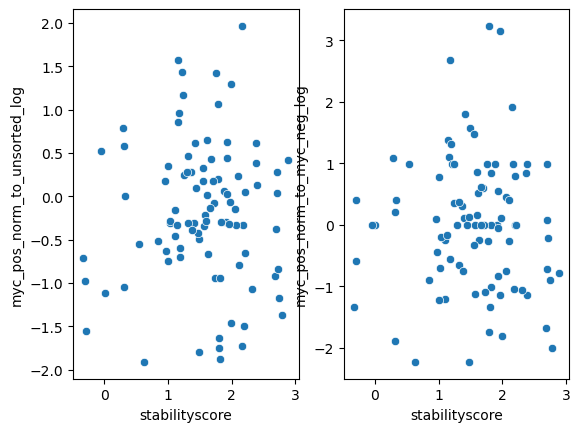

0.01735128616334115
-0.01819061741666962


In [498]:
plt.subplot(1,2,1)
sns.scatterplot(data=prot_stab_exp_df, x='stabilityscore', y='myc_pos_norm_to_unsorted_log')

plt.subplot(1,2,2)
sns.scatterplot(data=prot_stab_exp_df, x='stabilityscore', y='myc_pos_norm_to_myc_neg_log')
plt.show()

#correlation
print(prot_stab_exp_df['stabilityscore'].corr(prot_stab_exp_df['myc_pos_norm_to_unsorted_log'], method='pearson'))
print(prot_stab_exp_df['stabilityscore'].corr(prot_stab_exp_df['myc_pos_norm_to_myc_neg_log'], method='pearson'))

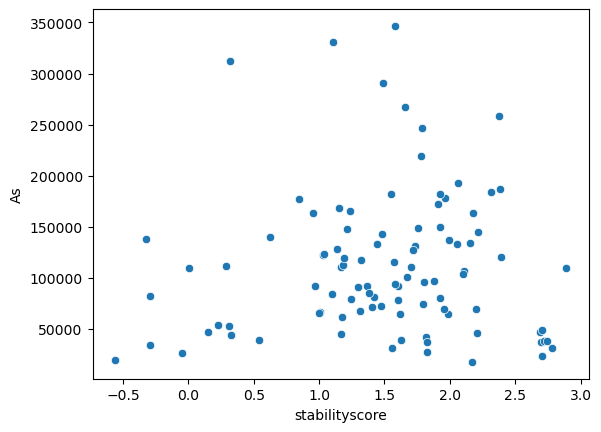

0.03523267564538781


In [499]:
sns.scatterplot(data=prot_stab_kds_df, x='stabilityscore', y='As')
plt.show()

#correlation
print(prot_stab_kds_df['As'].corr(prot_stab_kds_df['stabilityscore'], method='pearson'))

Next we can plot histograms of inferred Kds from tite-seq data for the min0 and min2 design groups. 

A clear bimodal population is observed with the two populations corresponding to the two design groups.

Notably, the non-binders still have quite a high kd (nM), but this matches with the negative control (bm01-alfa-t3, dashed orange line). 

Titration data for designs can be calculated independently of surface expression, but we have observed before that non-binders (eg a poly-Ala negative control) show low maximum fluorescence in single clone on-yeast measurements. 

For this reason, can toggle on and off filtering out designs with low upper asymptote (<5000) before plotting Kds. This doesn't seem to cause a major shift in the populations. 

In [500]:
#histogram of Kds by design group

designs_list = kds_df['design'].tolist()

min_type_list = []
for i in designs_list:
    if 'min_0' in i:
        min_type_list.append('min_0')
    elif 'min_2' in i:
        min_type_list.append('min_2')
    else:
        min_type_list.append('bm01_ctrl')

kds_df['design_type'] = min_type_list

#uncomment line below to plot only designs with max surface expression >5000
#kds_df = kds_df[kds_df['As'] > 5000]

sns.histplot(kds_df[kds_df['design_type'].isin(['min_0', 'min_2'])], x=-kds_df['Kds'], bins=13, hue='design_type', palette=['lightyellow', 'lightgreen']) #plot Kd as -log10 because easier to represent on histogram
plt.ylabel('Number of designs', fontsize=16)
plt.xlabel('Log10(Kd_app) (M)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#optional show positive and negative control
#comment or uncomment as desired
plt.axvline(x = -(kds_df.loc[kds_df['design'] == 'bm01_ALFA_t3', 'Kds'].item()), color = 'orange', linestyle='dashed', label = 'min0 ctrl')
plt.axvline(x = -(kds_df.loc[kds_df['design'] == 'bm01_ALFA_t6', 'Kds'].item()), color = 'green', linestyle='dashed', label = 'min2 ctrl')
#plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

#plt.show()
plt.savefig(f'{fig_outdir}/{exp_id}_kds_histplot_min0_min2_only.png', dpi=300, bbox_inches = 'tight')
plt.clf()

/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seabo

<Figure size 640x480 with 0 Axes>

We can also look by design group at the inferred Kds from tite-seq data relative to the expected binder and non-binder controls. Points are colored by stability score or log enrichment in myc+ population. 

In [501]:
#plotting stripplot for each design type colored by stability score

#filter out controls before plotting
prot_stab_kds_df = prot_stab_kds_df[prot_stab_kds_df['design'].str.contains('bm01_ALFA')==False]
prot_stab_kds_df = prot_stab_kds_df[prot_stab_kds_df['design'].str.contains('myc')==False]

prot_stab_kds_df[['design_id', 'design_type']] = prot_stab_kds_df['design'].str.split(r'ALFA_\d\d_\d{1,2}_', expand=True)

sns.stripplot(data=prot_stab_kds_df, x=-prot_stab_kds_df['Kds'], y='design_type', hue='stabilityscore', s=8, palette='mako',
              order=['min_0_52_bm01_loop', 'min_0_52_g4s_loop', 'min_0_53_bm01_loop', 'min_0_53_g4s_loop', 'min_2_52_bm01_loop', 'min_2_52_g4s_loop', 'min_2_53_bm01_loop', 'min_2_53_g4s_loop'])
plt.axvline(x = -(kds_df.loc[kds_df['design'] == 'bm01_ALFA_t3', 'Kds'].item()), color = 'orange', linestyle='dashed', label = 'min0 ctrl')
plt.axvline(x = -(kds_df.loc[kds_df['design'] == 'bm01_ALFA_t6', 'Kds'].item()), color = 'green', linestyle='dashed', label = 'min2 ctrl')
plt.xlabel('Log10(Kd_app) (M)', fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.show()
#plt.savefig(f'{fig_outdir}/{exp_id}_kds_colored_ss_stripplot.png', dpi=300, bbox_inches = 'tight')
plt.clf()

/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Figure size 640x480 with 0 Axes>

In [502]:
#plotting stripplot for each design type colored by log enrichment myc pos

#filter out controls before plotting
kds_exp_df = kds_exp_df[kds_exp_df['design'].str.contains('bm01_ALFA')==False]
kds_exp_df = kds_exp_df[kds_exp_df['design'].str.contains('myc')==False]

kds_exp_df[['design_id', 'design_type']] = kds_exp_df['design'].str.split(r'ALFA_\d\d_\d{1,2}_', expand=True)

sns.stripplot(data=kds_exp_df, x=-kds_exp_df['Kds'], y='design_type', hue='myc_pos_norm_to_myc_neg_log', s=8, palette='mako',
              order=['min_0_52_bm01_loop', 'min_0_52_g4s_loop', 'min_0_53_bm01_loop', 'min_0_53_g4s_loop', 'min_2_52_bm01_loop', 'min_2_52_g4s_loop', 'min_2_53_bm01_loop', 'min_2_53_g4s_loop'])
plt.axvline(x = -(kds_df.loc[kds_df['design'] == 'bm01_ALFA_t3', 'Kds'].item()), color = 'orange', linestyle='dashed', label = 'min0 ctrl')
plt.axvline(x = -(kds_df.loc[kds_df['design'] == 'bm01_ALFA_t6', 'Kds'].item()), color = 'green', linestyle='dashed', label = 'min2 ctrl')
plt.xlabel('Log10(Kd_app) (M)', fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.show()
#plt.savefig(f'{fig_outdir}/{exp_id}_kds_colored_myc_pos_stripplot.png', dpi=300, bbox_inches = 'tight')
plt.clf()

/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/plotting/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Figure size 640x480 with 0 Axes>

Plotting all metrics on one plot by design group. 

Log Kds are binned according to their difference from the expected Kd (from the control-bm01-alfa-t3 for min0 and bm01-alfa-t6 for min2).

Designs with intermediate lower binding than expected among the min2 group could be candidate switches. 

Plotting for expression based on myc+ enrichment (>0) and also upper asymptote from tite-seq fits (>5000). 

In [503]:
#plotting scatterplot of expression vs stability score

#in order to see how inferred Kd deviates from expected, adding column for Kd normalized to expected Kd
#expected Kd for min0 is taken from bm01_ALFA_t3, for min2 from bm01_ALFA_t6 (subtracting because in log scale)
min0_df = all_merge_df[all_merge_df['design'].str.contains('min_0')]
min0_df['Kds_norm_to_expected'] = min0_df['Kds'] - kds_df.loc[kds_df['design'] == 'bm01_ALFA_t3', 'Kds'].item()

min2_df = all_merge_df[all_merge_df['design'].str.contains('min_2')]
min2_df['Kds_norm_to_expected'] = min2_df['Kds'] - kds_df.loc[kds_df['design'] == 'bm01_ALFA_t6', 'Kds'].item()

dfs_to_concat = [min0_df, min2_df]
min0_min2_df = pd.concat(dfs_to_concat)

#bin normalized kds
bins = [-10, -1, -0.5, 0.5, 10]
labels = ['lower Kd', 'intermediate lower Kd', 'expected Kd', 'higher Kd']
min0_min2_df['Kds_norm_to_expected_binned'] = pd.cut(min0_min2_df['Kds_norm_to_expected'], bins=bins, labels=labels)

conditions_to_plot = ['min_0_52_bm01_loop', 'min_0_52_g4s_loop', 'min_0_53_bm01_loop', 
                      'min_0_53_g4s_loop', 'min_2_52_bm01_loop', 'min_2_52_g4s_loop', 'min_2_53_bm01_loop', 'min_2_53_g4s_loop']

for condition in conditions_to_plot:
    sns.scatterplot(data=min0_min2_df[min0_min2_df['min_type'] == f'{condition}'], x='stabilityscore', y='myc_pos_norm_to_myc_neg_log', s=100,
                hue='Kds_norm_to_expected_binned', palette='rocket')
    plt.axvline(x=1, color = 'black')
    plt.axhline(y=0, color = 'black')
    plt.xlabel('Stability score', fontsize=16)
    plt.ylabel('Log norm enrichment myc pos', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f'{condition}', fontsize=16)
    #plt.show()
    #plt.savefig(f'{fig_outdir}/{exp_id}_{condition}_ss_vs_myc_pos_log_expected_binding.png', dpi=300, bbox_inches = 'tight')
    plt.clf()


/var/folders/7h/sws1byhj2pzb__hgp1w6_3j80000gn/T/ipykernel_30968/3042782536.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min0_df['Kds_norm_to_expected'] = min0_df['Kds'] - kds_df.loc[kds_df['design'] == 'bm01_ALFA_t3', 'Kds'].item()
/var/folders/7h/sws1byhj2pzb__hgp1w6_3j80000gn/T/ipykernel_30968/3042782536.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min2_df['Kds_norm_to_expected'] = min2_df['Kds'] - kds_df.loc[kds_df['design'] == 'bm01_ALFA_t6', 'Kds'].item()


<Figure size 640x480 with 0 Axes>

Also plotting As of fit curve as measure of expression. In general, pretty much everything above a minimum cutoff so this doesn't seem to be very informative. 

In [504]:
#plotting scatterplot of As vs stability score

#in order to see how inferred Kd deviates from expected, adding column for Kd normalized to expected Kd
#expected Kd for min0 is taken from bm01_ALFA_t3, for min2 from bm01_ALFA_t6 (subtracting because in log scale)
min0_df = all_merge_df[all_merge_df['design'].str.contains('min_0')]
min0_df['Kds_norm_to_expected'] = min0_df['Kds'] - kds_df.loc[kds_df['design'] == 'bm01_ALFA_t3', 'Kds'].item()

min2_df = all_merge_df[all_merge_df['design'].str.contains('min_2')]
min2_df['Kds_norm_to_expected'] = min2_df['Kds'] - kds_df.loc[kds_df['design'] == 'bm01_ALFA_t6', 'Kds'].item()

dfs_to_concat = [min0_df, min2_df]
min0_min2_df = pd.concat(dfs_to_concat)

#bin normalized kds
bins = [-10, -1, -0.5, 0.5, 10]
labels = ['lower binding', 'intermediate low', 'expected binding', 'higher binding']
min0_min2_df['Kds_norm_to_expected_binned'] = pd.cut(min0_min2_df['Kds_norm_to_expected'], bins=bins, labels=labels)

conditions_to_plot = ['min_0_52_bm01_loop', 'min_0_52_g4s_loop', 'min_0_53_bm01_loop', 
                      'min_0_53_g4s_loop', 'min_2_52_bm01_loop', 'min_2_52_g4s_loop', 'min_2_53_bm01_loop', 'min_2_53_g4s_loop']

for condition in conditions_to_plot:
    sns.scatterplot(data=min0_min2_df[min0_min2_df['min_type'] == f'{condition}'], x='stabilityscore', y='As', s=100,
                hue='Kds_norm_to_expected_binned', palette='rocket')
    plt.axvline(x=1, color = 'black')
    plt.axhline(y=5000, color = 'black')
    plt.xlabel('Stability score', fontsize=16)
    plt.ylabel('Inferred design_tot (As)', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f'{condition}', fontsize=16)
    #plt.show()
    #plt.savefig(f'{fig_outdir}/{exp_id}_{condition}_ss_vs_inferred_As_binding.png', dpi=300, bbox_inches = 'tight')
    plt.clf()


/var/folders/7h/sws1byhj2pzb__hgp1w6_3j80000gn/T/ipykernel_30968/3756857932.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min0_df['Kds_norm_to_expected'] = min0_df['Kds'] - kds_df.loc[kds_df['design'] == 'bm01_ALFA_t3', 'Kds'].item()
/var/folders/7h/sws1byhj2pzb__hgp1w6_3j80000gn/T/ipykernel_30968/3756857932.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min2_df['Kds_norm_to_expected'] = min2_df['Kds'] - kds_df.loc[kds_df['design'] == 'bm01_ALFA_t6', 'Kds'].item()


<Figure size 640x480 with 0 Axes>